A mesma base de dados que vem sendo trabalhada na disciplina também será usada aqui.

O problema agora é montar modelos para classificar postagens entre engajamento alto e aquelas que não geraram engajamento alto.
Define-se engajamento alto como as postagens com engajament_total entre os 25% maiores valores (como no Trabalho 4).
Aqui, as variáveis que foram usadas para calcular engajament_total não devem ser usadas como atributos para o modelo.

Vocês devem desenvolver modelos para ao menos 2 tipos de classificadores, sendo que ao menos um deles deve possibilitar extrair algum conhecimento; apresente isso (atributos importantes ou regras condicionais, por exemplo).
Deve-se:
- melhorar o tratamento dos dados, se necessário;
- adotar uma estratégia experimental adequada;
- avaliar comparativamente os modelos, incluindo análises de hiper-parâmetros;
- tratar o desbalanceamento dos dados; e
- extrair conhecimento de ao menos um dos modelos.

O conteúdo a ser enviado é:
(1) apresentação do desenvolvimento do trabalho e resultados alcançados (não mais que 15min),
(2) códigos (notebooks em arquivo ipynb, se preferirem) usados na resolução do trabalho.
Os códigos são apenas para consulta/dúvidas e não fazem parte da avaliação. Como comentado antes, a apresentação pode ser feita via slides ou num notebook (por exemplo, do Google Colab) e pode conter os códigos usados no trabalho. Neste caso, não precisa enviar os códigos num arquivo separado. Vale destacar que não é obrigatório usar Python e Google Colab.

In [112]:
import math
from functools import reduce
from math import floor

from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils import *
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import seaborn as sns


In [113]:
def binarize_categorical_columns(df, columns):
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df.drop(column, axis=1, inplace=True)
    return df


In [114]:
df = pd.read_csv('preprocessing_result1.csv')
df['engagement_total'] = ((df['likes'] + df['num_comments'] + df['video_view_count'])/(df['followers']+1))*100
df['high_engagement'] = np.where(df['engagement_total'] >= df['engagement_total'].quantile(0.75), True, False)
df['low_engagement'] = ~ df['high_engagement']
df = binarize_categorical_columns(df, ['content_type', 'tone', 'emotion_displayed', 'location_type'])
len_df = len(df)
print(f'Número de linhas: {len_df}')

df_y = df['high_engagement']#[:-floor(len_df*0.3)]
df_x = df.drop(columns=['engagement_total', 'likes', 'num_comments', 'video_view_count', 'followers', 'high_engagement', 'low_engagement'])#[:-floor(len_df*0.3)]
df

Número de linhas: 983


,followers,likes,num_comments,video_view_count,has_a_person,vape_present,is_vaping,img_mentions_brands,text_mentions_brands,Health_ad,...,emotion_displayed_supportive,emotion_displayed_surprise,emotion_displayed_thoughtful,emotion_displayed_tired,location_type_Commercial,location_type_Indoor,location_type_Neutral,location_type_Outdoor,location_type_Private,location_type_Public
0,0.666791,0.09375,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,True
1,0.058824,0.06250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,True
2,1.000000,0.37500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,True,False,False,False,False
3,0.002978,0.09375,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
4,0.118019,0.21875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.067759,0.12500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,True
979,0.970588,0.25000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,True
980,0.003723,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,True
981,0.193596,1.00000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False


In [115]:
# from sklearn.decomposition import PCA
#
# pca = PCA(n_components=10)
# X_pca = pca.fit_transform(df_x)
# X_pca

In [116]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

nTestes = 30

metricas_nb = []
metricas_rf = []



for i in range(nTestes):
    naive_bayes = GaussianNB()
    random_forest = RandomForestClassifier(n_estimators=100, random_state=i)
    xTreino, xTeste, yTreino, yTeste = train_test_split( df_x, df_y, test_size=0.3, random_state=i )
    scaler = preprocessing.StandardScaler()
    xTreino = scaler.fit_transform( xTreino )
    xTeste = scaler.transform( xTeste )
    # treinar modelo NB
    naive_bayes.fit(xTreino, yTreino)
    yPredito = naive_bayes.predict( xTeste )

    metricas_nb.append({
        'accuracy': accuracy_score(yTeste, yPredito),
        'precision': precision_score(yTeste, yPredito),
        'recall': recall_score(yTeste, yPredito),
        'f1': f1_score(yTeste, yPredito)
    })

    # treinar modelo LR
    random_forest.fit(xTreino, yTreino)
    yPredito = random_forest.predict( xTeste )


    metricas_rf.append({
        'accuracy': accuracy_score(yTeste, yPredito),
        'precision': precision_score(yTeste, yPredito),
        'recall': recall_score(yTeste, yPredito),
        'f1': f1_score(yTeste, yPredito)
    })



In [117]:
pd.DataFrame(metricas_nb)

,accuracy,precision,recall,f1
0,0.291525,0.263345,0.973684,0.414566
1,0.254237,0.234043,0.942857,0.375000
2,0.264407,0.240283,0.971429,0.385269
3,0.264407,0.245614,0.972222,0.392157
4,0.281356,0.259649,0.986667,0.411111
5,0.267797,0.242857,0.944444,0.386364
6,0.261017,0.235915,0.985294,0.380682
7,0.281356,0.238267,0.985075,0.383721
8,0.294915,0.266187,0.948718,0.415730
9,0.261017,0.242958,0.958333,0.387640


In [118]:
pd.DataFrame(metricas_rf)

,accuracy,precision,recall,f1
0,0.688136,0.340000,0.223684,0.269841
1,0.742373,0.411765,0.200000,0.269231
2,0.752542,0.463415,0.271429,0.342342
3,0.745763,0.434783,0.138889,0.210526
4,0.762712,0.575758,0.253333,0.351852
5,0.691525,0.313725,0.222222,0.260163
6,0.776271,0.533333,0.235294,0.326531
7,0.769492,0.484848,0.238806,0.320000
8,0.732203,0.487805,0.256410,0.336134
9,0.752542,0.482759,0.194444,0.277228


# Avaliação dos modelos Random Forest e Naive Bayes

In [140]:
def model_report(estimator, x, y):
    scores = cross_validate(estimator, x, y, cv=10,
                        #scoring=('accuracy', 'precision', 'recall', 'f1', confusion_matrix_scorer),
                        #scoring dictionary
                        scoring={
                            'accuracy': 'accuracy',
                            'precision': 'precision',
                            'recall': 'recall',
                            'f1': 'f1',
                            #'confusion_matrix': confusion_matrix_scorer
                        },
                        return_train_score=True)

    print(f'train_accuracy: {scores["train_accuracy"].mean():.3f}, test_accuracy: {scores["test_accuracy"].mean():.3f}')
    print(f"train_precision: {scores['train_precision'].mean():.3f}, test_precision: {scores['test_precision'].mean():.3f}")
    print(f"train_recall: {scores['train_recall'].mean():.3f}, test_recall: {scores['test_recall'].mean():.3f}")
    print(f"train_f1: {scores['train_f1'].mean():.3f}, test_f1: {scores['test_f1'].mean():.3f}")

    y_pred = cross_val_predict(estimator, df_x, df_y, cv=10)
    conf_mat = confusion_matrix(df_y, y_pred)
    print(conf_mat)


    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
               xticklabels=['LOW', 'HIGH'],
            yticklabels=['LOW', 'HIGH']
                )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    #roc cuve plot
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import RocCurveDisplay
    y_binarized = label_binarize(y, classes=[False, True])
    y_score = cross_val_predict(estimator, df_x, df_y, cv=10
        , method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(y_binarized, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


train_accuracy: 0.971, test_accuracy: 0.729
train_precision: 0.983, test_precision: 0.427
train_recall: 0.901, test_recall: 0.199
train_f1: 0.940, test_f1: 0.264
[[668  69]
 [197  49]]


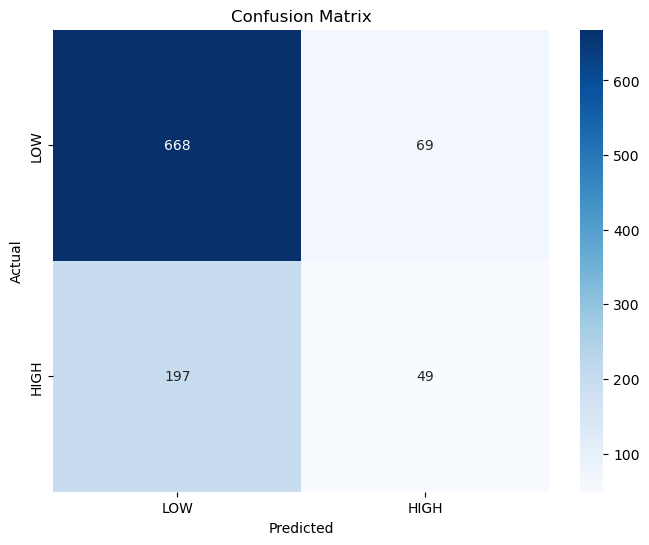

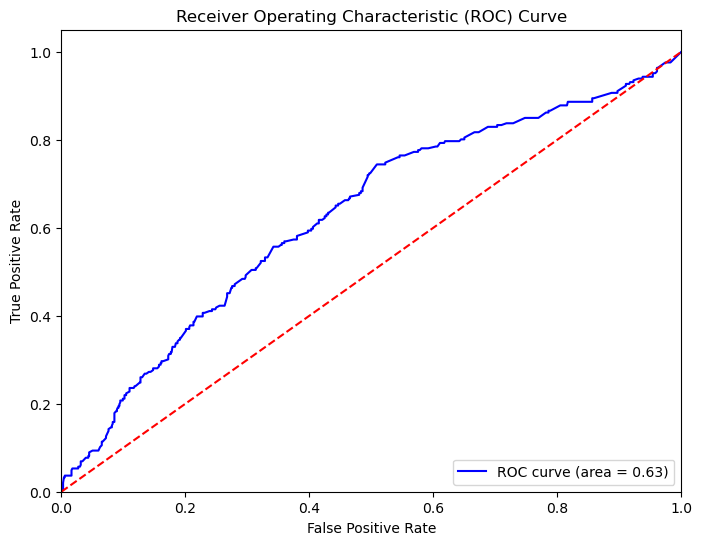

In [141]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_report(random_forest, df_x, df_y)

train_accuracy: 0.307, test_accuracy: 0.279
train_precision: 0.265, test_precision: 0.255
train_recall: 1.000, test_recall: 0.976
train_f1: 0.420, test_f1: 0.404
[[ 34 703]
 [  6 240]]


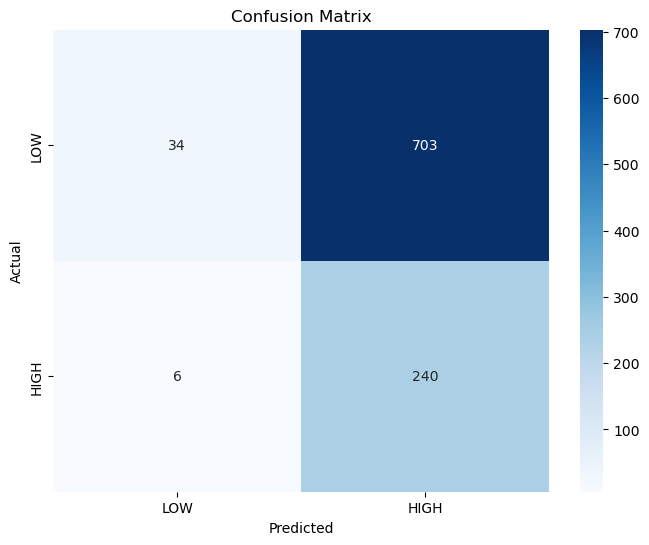

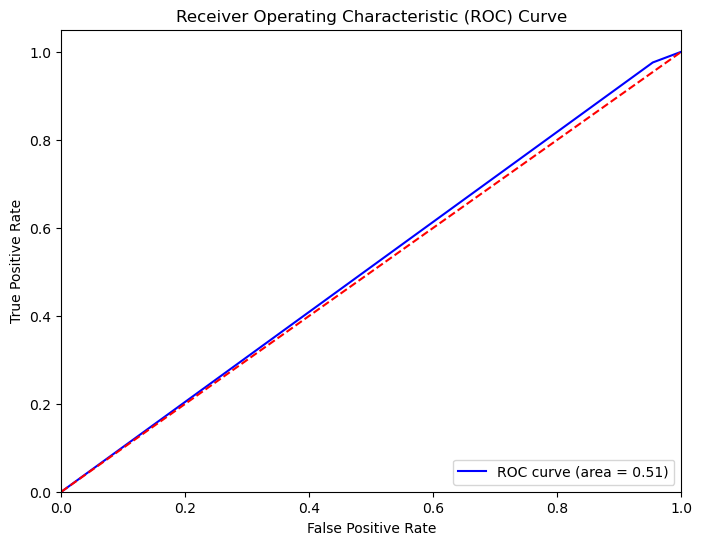

In [142]:
naive_bayes = GaussianNB()
model_report(naive_bayes, df_x, df_y)

# Importância dos atributos no modelo Random Forest

In [ ]:
import time
from sklearn.inspection import permutation_importance

xTreino, xTeste, yTreino, yTeste = train_test_split( df_x, df_y, test_size=0.3, random_state=13 )
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(xTreino, yTreino)

feature_names = [f"feature {i}" for i in range(df_x.shape[1])]
start_time = time.time()
result = permutation_importance(
    random_forest, df_x, df_y, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

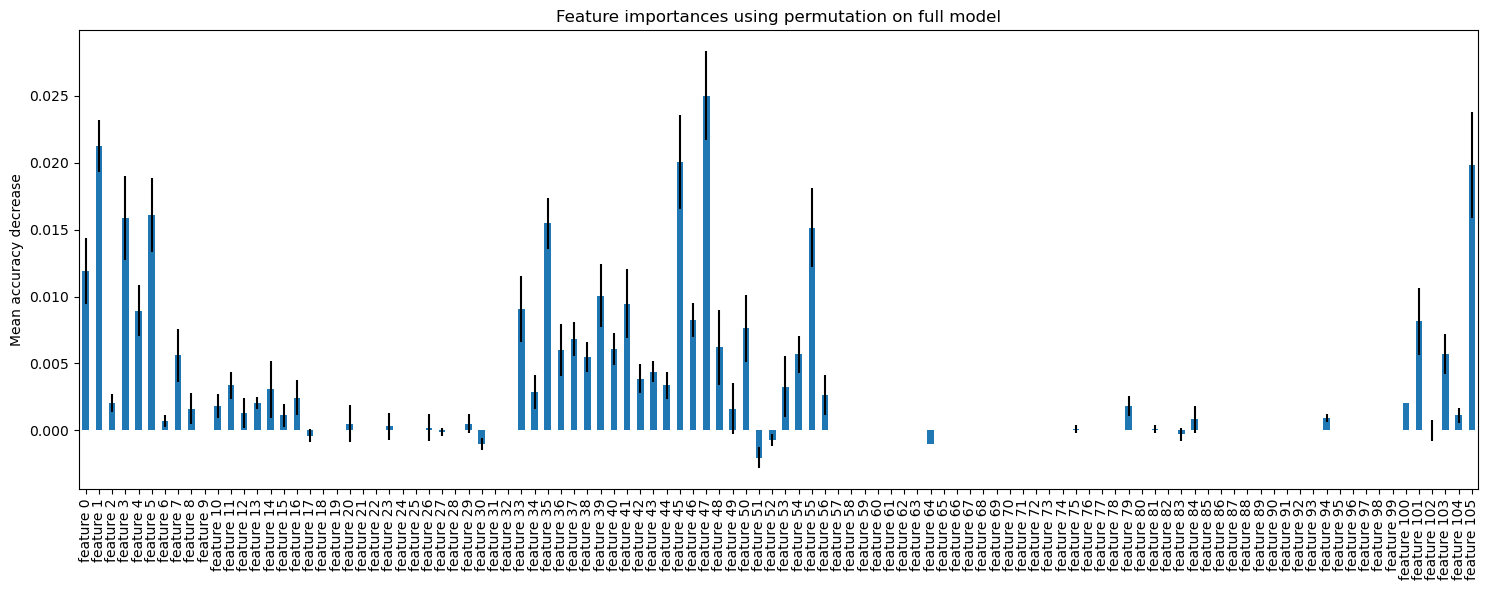

In [127]:

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
#figsize
fig.set_size_inches(15, 6)
fig.tight_layout()
plt.show()

<Axes: >

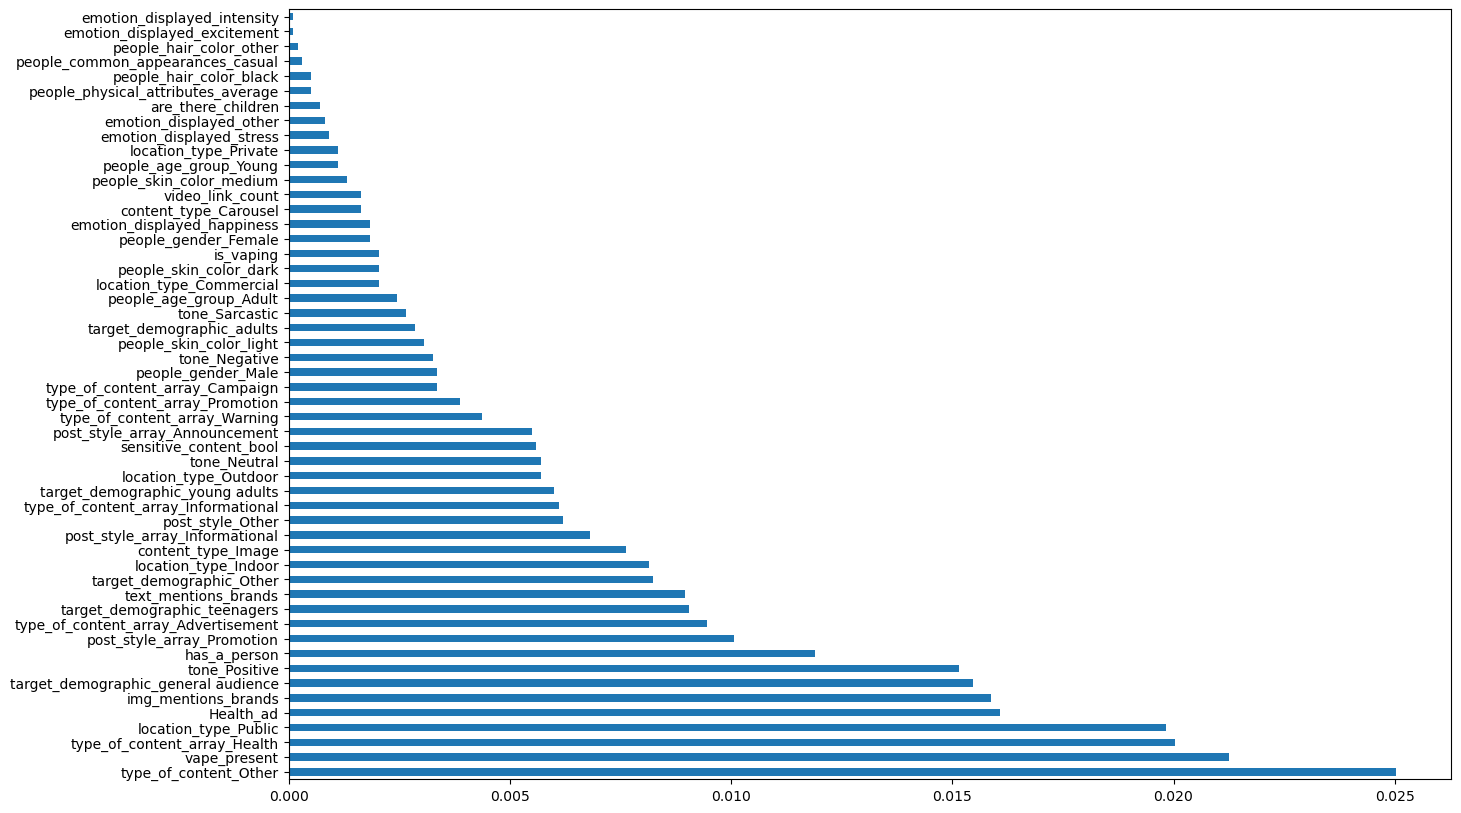

In [135]:
# get actual feature names
feature_names = df_x.columns.tolist()
forest_importances = pd.Series(result.importances_mean, index=feature_names, name='Importance')

forest_importances[forest_importances > 0].sort_values(ascending=False).plot(kind='barh', figsize=(15, 10))

In [139]:
forest_importances[forest_importances > 0].index.tolist()

['has_a_person',
 'vape_present',
 'is_vaping',
 'img_mentions_brands',
 'text_mentions_brands',
 'Health_ad',
 'are_there_children',
 'sensitive_content_bool',
 'video_link_count',
 'people_gender_Female',
 'people_gender_Male',
 'people_skin_color_medium',
 'people_skin_color_dark',
 'people_skin_color_light',
 'people_age_group_Young',
 'people_age_group_Adult',
 'people_physical_attributes_average',
 'people_common_appearances_casual',
 'people_hair_color_other',
 'people_hair_color_black',
 'target_demographic_teenagers',
 'target_demographic_adults',
 'target_demographic_general audience',
 'target_demographic_young adults',
 'post_style_array_Informational',
 'post_style_array_Announcement',
 'post_style_array_Promotion',
 'type_of_content_array_Informational',
 'type_of_content_array_Advertisement',
 'type_of_content_array_Promotion',
 'type_of_content_array_Warning',
 'type_of_content_array_Campaign',
 'type_of_content_array_Health',
 'target_demographic_Other',
 'type_of_cont